# [데이콘 온라인 스터디] 2주차 - 탐색적 데이터 분석(EDA)

## 불균형한 데이터 분포, 어떻게 처리해야 할까?

지난 6월부터 7월 중순까지 약 4주간에 걸쳐 원자력 상태판단대회 온라인 스터디(2기)가 진행되었습니다. 스터디에서 진행한 내용을 보다 많은 분들과 고민하고자 앞으로 3차례에 걸쳐 코드공유 게시물을 업로드할 예정입니다.

온라인 스터디와 관련한 자료는 아래 링크를 참조해 주세요.

- 데이콘 온라인 스터디 커리큘럼 [바로가기](https://www.dropbox.com/scl/fi/eaxxhf0pudm9jvckqgf4k/.papert?dl=0&rlkey=yqyrpk9eluqauoi5xjmywmp66)
- 2주차 세션 진행 자료 [바로가기](https://www.dropbox.com/scl/fi/qezpyfkbj0om86afkk3bs/2.paper?dl=0&rlkey=i4nysx05x2tgy26mlkpu6cdhm)

------

두번째 주제는 <불균형한 데이터 분포, 어떻게 처리해야 할까?>로, 데이터의 분포도를 살펴보고 데이터 분포의 불균형이 초래할 수 있는 문제와 리샘플링 방법에 대해 다뤄보고자 합니다.

*(이하 내용은 원자력 온라인 스터디 1, 2기에서 다루었던 내용이 포함되어 있습니다.)*

-------------

### 1. 데이터 로드

데이터 로드 시 데이콘에서 제공한 베이스라인 코드를 참조하였습니다.

다만, 상태 A에서 B로 변화하는 ~15초 구간, 즉 event_time변수 값을 기존 10에서 15로 변경하여 모든 측정치가 상태 B인 구간만을 사용하였습니다.

우승자 코드를 살펴보면 일부 팀에서 1초부터 15초 까지 1초간 변화를 주어 약 15개의 데이터셋을 활용하여 모델을 구성하기도 했는데, 각 측정치마다 변화 시점이 같다고 판단하기 어려우므로 상태 B에 대해 집중하기로 결정하였습니다.

상태 A와 B에 대해 상관관계를 도출하고자 여러 시도를 했는데, 유의미한 인사이트를 아직 얻지 못했습니다. 이 부분에 대해서는 조금 더 고민을 해봐야 할 것 같습니다.

추가로, nrows는 75로 설정하여 60초의 데이터를 가져올 수 있도록 하였습니다.

In [3]:
import multiprocessing 
from multiprocessing import Pool 
from functools import partial 
from data_loader_v2 import data_loader_v2
import os 
import pandas as pd
import numpy as np
import joblib

In [4]:
train_folder = 'train/'
train_list = os.listdir(train_folder)
train_label_path = 'train_label.csv'
train_label = pd.read_csv(train_label_path, index_col=0)

In [5]:
def data_loader_all_v2(func, files, folder='', train_label=None, event_time=15, nrows=75):   
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)  
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(pool.imap(func_fixed, files)) 
        pool.close() 
        pool.join() 
    combined_df = pd.concat(df_list)
    return combined_df

In [6]:
# event_time=15, nrows=75 설정
train = data_loader_all_v2(data_loader_v2, train_list, folder=train_folder, train_label=train_label, event_time=15, nrows=75)

---------

### 2. 데이터 처리

본 대회의 데이터는 칼럼이 많은 것이 특징입니다. 약 5000여개의 칼럼에서 row에 따라 값이 변하지 않는 칼럼은 의미없는 칼럼으로 간주하여 해당 칼럼을 삭제하는 작업을 진행하였습니다.

1) 유니크한 값의 개수가 1인 칼럼, 2) 표준편차가 0인 칼럼을 제거하는 방식을 적용하였습니다. 두 방법이 비슷해 보이지만, 1)의 경우 1783개, 2)의 경우 1693개의 칼럼이 삭제되어 약 100개 정도 차이가 있었습니다.

이 차이에 대해서는 스터디원 '인호베이션97'님 께서 토론 게시물을 작성해 주셨습니다. [링크](https://dacon.io/competitions/official/235551/talkboard/401155?page=1&dtype=recent&ptype=pub)를 참조해주세요.

In [8]:
#원본 데이터 크기
train.shape

(49620, 5122)

In [9]:
#칼럼 drop ver1 : nunique()!=1
train_1 = train.loc[:,train.nunique()!=1]
train_1.shape

(49620, 3339)

In [44]:
#칼럼 drop ver2 : train.std()!=0
train_2 = train.loc[:,train.std()!=0]
train_2.shape

(49620, 3429)

In [11]:
X_train = train.drop(['label'], axis=1)
y_train = train['label']

X_train_1 = train_1.drop(['label'], axis=1)
y_train_1 = train_1['label']

X_train_2 = train_2.drop(['label'], axis=1)
y_train_2 = train_2['label']

단순 rf모델로 칼럼 축소 성능을 비교해보겠습니다. 사이킷런의 cross_val_score 결과상으로는 미세한 차이이나, 본 대회의 평가지표, log loss를 고려한다면 작은 차이라도 리더보드상 결과는 크게 달라질 수 있기에 2)안을 채택하여 칼럼을 drop할 수 있었습니다. (물론, train 데이터에서 drop된 칼럼은 test에서도 동일하게 drop되었습니다.)

In [42]:
#칼럼제거 성능평가
#원본 데이터세트
#랜덤 포레스트 이용해 타깃 값이 디폴트 값을 3개 교차 검증 세트로 분류 예측
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf=RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rcf, X_train, y_train, scoring='accuracy', cv=3)
print('원본\nCV3인 경우 개별 fold 세트별 정확도 : ', scores)
print('평균 정확도 : {0:.4f}'.format(np.mean(scores)))

원본
CV3인 경우 개별 fold 세트별 정확도 :  [0.7795827 0.80259345 0.79941585]
평균 정확도 : 0.7939


In [29]:
#칼럼 drop ver1
rcf_1=RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rcf_1, X_train_1, y_train_1, scoring='accuracy', cv=3)
print('CV3인 경우 개별 fold 세트별 정확도 : ', scores)
print('평균 정확도 : {0:.4f}'.format(np.mean(scores)))

CV3인 경우 개별 fold 세트별 정확도 :  [0.80912938 0.82091898 0.82025393]
평균 정확도 : 0.8168


In [46]:
#칼럼 drop ver2
rcf_2=RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rcf_2, X_train_2, y_train_2, scoring='accuracy', cv=3)
print('CV3인 경우 개별 fold 세트별 정확도 : ', scores)
print('평균 정확도 : {0:.4f}'.format(np.mean(scores)))

CV3인 경우 개별 fold 세트별 정확도 :  [0.81737606 0.82128174 0.81741233]
평균 정확도 : 0.8187


결과적으로 5122개의 칼럼에서 3339여개의 칼럼으로 축소할 수 있었습니다. 

-----

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings

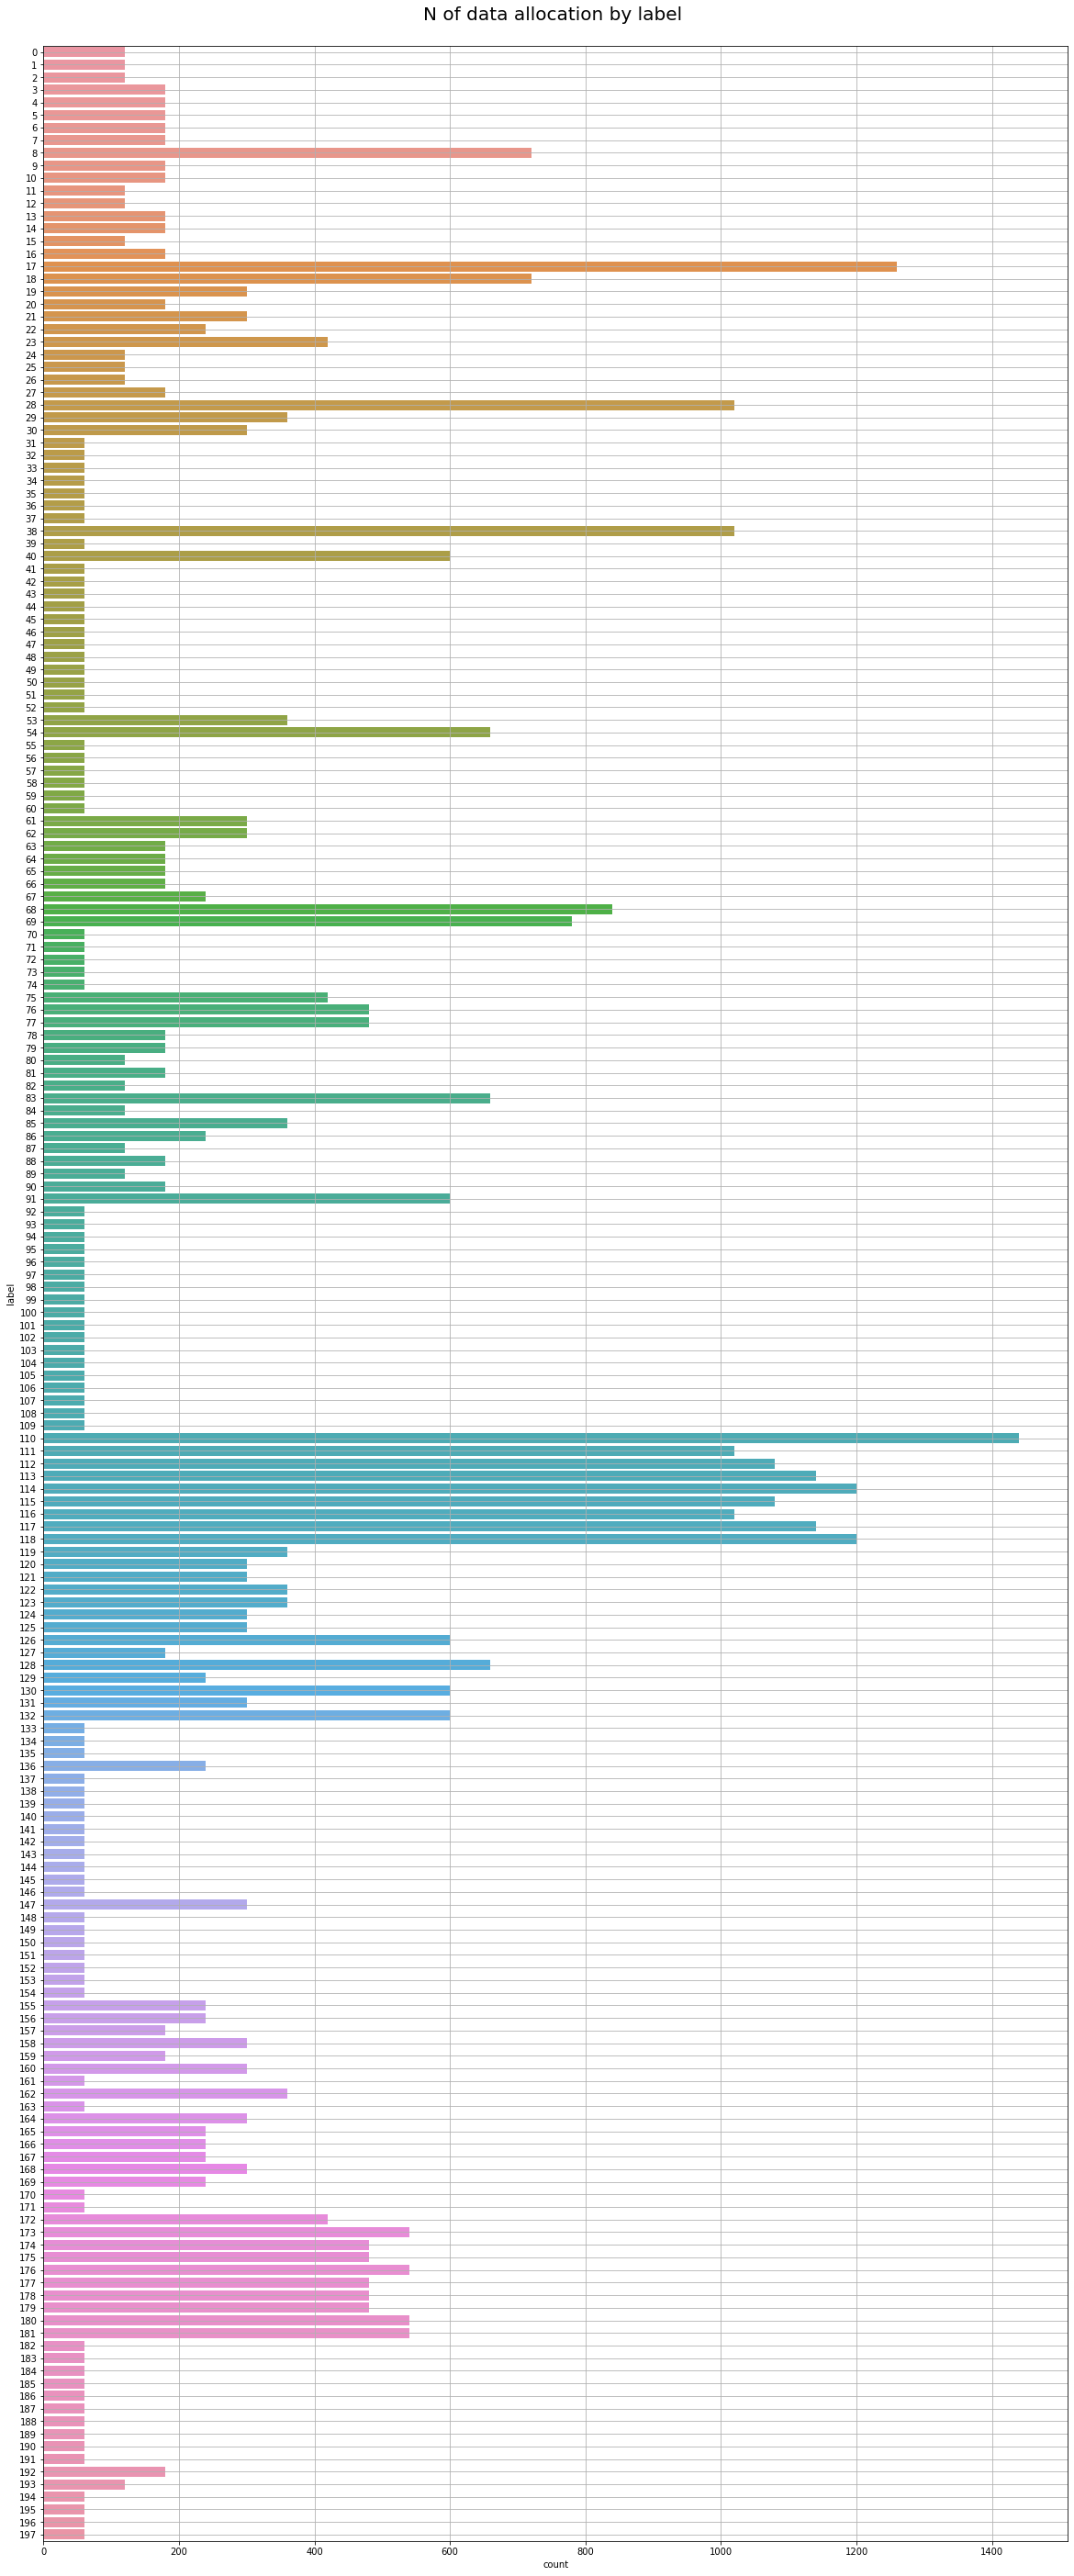

In [17]:
#라벨 별 분포도
warnings.filterwarnings(action='ignore')
plt.figure(figsize=(20, 50))
sns.countplot(y=y_train)
plt.title('N of data allocation by label \n', size=20)
plt.grid()

plt.show()

110라벨의 경우 약 24여개의 데이터가 포함된 반면 일부 라벨은 1개의 데이터만 포함된 경우도 더러 있습니다. 데이터의 불균형한 분포가 부적절하다고 판단하여 균형을 맞출 수 있도록 리샘플링을 진행하는 것으로 결정했습니다.

불균형한 데이터 문제를 해결하기 위해서는 분류 알고리즘 자체의 성능을 향상시키거나, 리샘플링하여 균형을 맞추는 방법이 고려됩니다. 리샘플링을 위해서는 데이터셋 내에서 상대적으로 다수를 차지하는 클래스의 비중을 낮추기 위해 1) 적은 클래스의 비중을 높이거나(Over-Sampling), 2) 다수를 차지하는 클래스를 줄이는 방법(Under-Sampling)등이 있습니다.

리샘플링 방법과 결과에 대해서는 다음 게시물에서 살펴보도록 하겠습니다.

-----

### 4. 데이터 리샘플링

데이터를 리샘플링 하는 방법에 대해서는 다양한 논의가 이루어졌습니다. 2안으로 나누어 설명하겠습니다.

#### <1안. Under-Sampling>

**라벨 별 데이터를 최소값인 1개로 재 할당**하는 방법입니다. train_label에서 라벨의 중복값을 제거한 id를 사용한다면 데이터의 할당 개수를 맞출 수 있습니다.

이때 기존 데이터 셋 크기에 비해 적은 양의 데이터셋이 구성되는데, 이를 보완하고자 nrows변수를 베이스라인 기준 60에서 300으로 임의 확장하여 부족한 데이터 보충할 수 있도록 구성하였습니다.

그러나 라벨 별 할당한 데이터가 과연 해당 라벨을 대표할 수 있는지 한계가 있습니다. 따라서 대표값을 논리적으로 산정할 수 있도록 분산 분석으로 전제를 확인해야 할 필요가 있습니다.

대표값 산정을 위한 분석을 진행하였으나, 어떤 데이터가 대표성을 띄는지 결론을 내기 어려웠습니다. 이 점도 조금 더 고민해서 좋은 결과가 있으면 추가로 공유하도록 하겠습니다.



#### <2안. Over-Sampling>

**라벨 별 데이터를 최대값인 24개로 재 할당**하는 방법입니다. 각 train 데이터가 완전히 상태 B인 이후 time(15~)에서 데이터 임의 분할(예. 15-75, 75-135, … ~599)하여 구성된 데이터 묶음을 기준으로 라벨 별 데이터를 할당한다면 적은 클래스를 효과적으로 확장할 수 있습니다.

라벨에 1개의 id의 데이터만 포함되더라도 부족한 데이터를 보충할 수 있어 불균형을 해소할 수 있으나, 그러나 시간(row)이 데이터 값에 큰 영향을 미칠 수 있다는 한계가 있습니다. 따라서 데이터의 임의 분할 과정에서 row값에 크게 영향을 받지 않는다는 전제를 확인할 필요가 있습니다.



이 중 1안인 Under-Sampling 방식을 채택하여 리샘플링을 진행하였으며 결과는 다음과 같습니다.



In [1]:
import multiprocessing 
from multiprocessing import Pool 
from functools import partial 
from data_loader_v2 import data_loader_v2
import os 
import pandas as pd
import numpy as np
import joblib

In [2]:
train_folder = 'train/'
train_list = os.listdir(train_folder)
train_label_path = 'train_label.csv'
train_label = pd.read_csv(train_label_path, index_col=0)

In [3]:
# Under-Sampling - label 별 1개의 파일 할당
sample_list = list(train_label.drop_duplicates().index)
train_list = [f'{i}.csv' for i in sample_list]

In [4]:
# event_time, nrows 변수 조정
# event_time = 15, nrows = 200
def data_loader_all_v2(func, files, folder='', train_label=None, event_time=15, nrows=200):
    func_fixed = partial(func, folder=folder, train_label=train_label, event_time=event_time, nrows=nrows)     
    if __name__ == '__main__':
        pool = Pool(processes=multiprocessing.cpu_count()) 
        df_list = list(pool.imap(func_fixed, files)) 
        pool.close()
        pool.join()        
    combined_df = pd.concat(df_list)    
    return combined_df

In [5]:
# train_list 반영하여 새로운 train 셋 구성
train = data_loader_all_v2(data_loader_v2, train_list, folder=train_folder, train_label=train_label)

In [6]:
train = train.loc[:, train.std() != 0]

In [7]:
X_train = train.drop(['label'], axis=1)
y_train = train['label']

In [8]:
X_train.shape, y_train.shape

((36630, 3455), (36630,))

----

데이터를 불러온 후, Under-Sampling 을 하여 데이터 개수 최소값인 1에 맞춰 임의로 1개의 id만 할당한 결과입니다. 성능 저하의 폭만 확인하기 위해 할당한 id는 데이터 묶음의 첫 id로 배정했습니다. (예. 110라벨에 대한 id가 18, 26, 112, 115, 190 ... 일 때 18만 할당하고 나머지 데이터는 제거)

라벨별 데이터 분포도를 시각화하여 살펴보겠습니다. 참고로 기존 라벨별 데이터 분포도는 아래 그래프를 참고해 주세요.

![다운로드](https://ifh.cc/g/gsTms8.png)





In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings

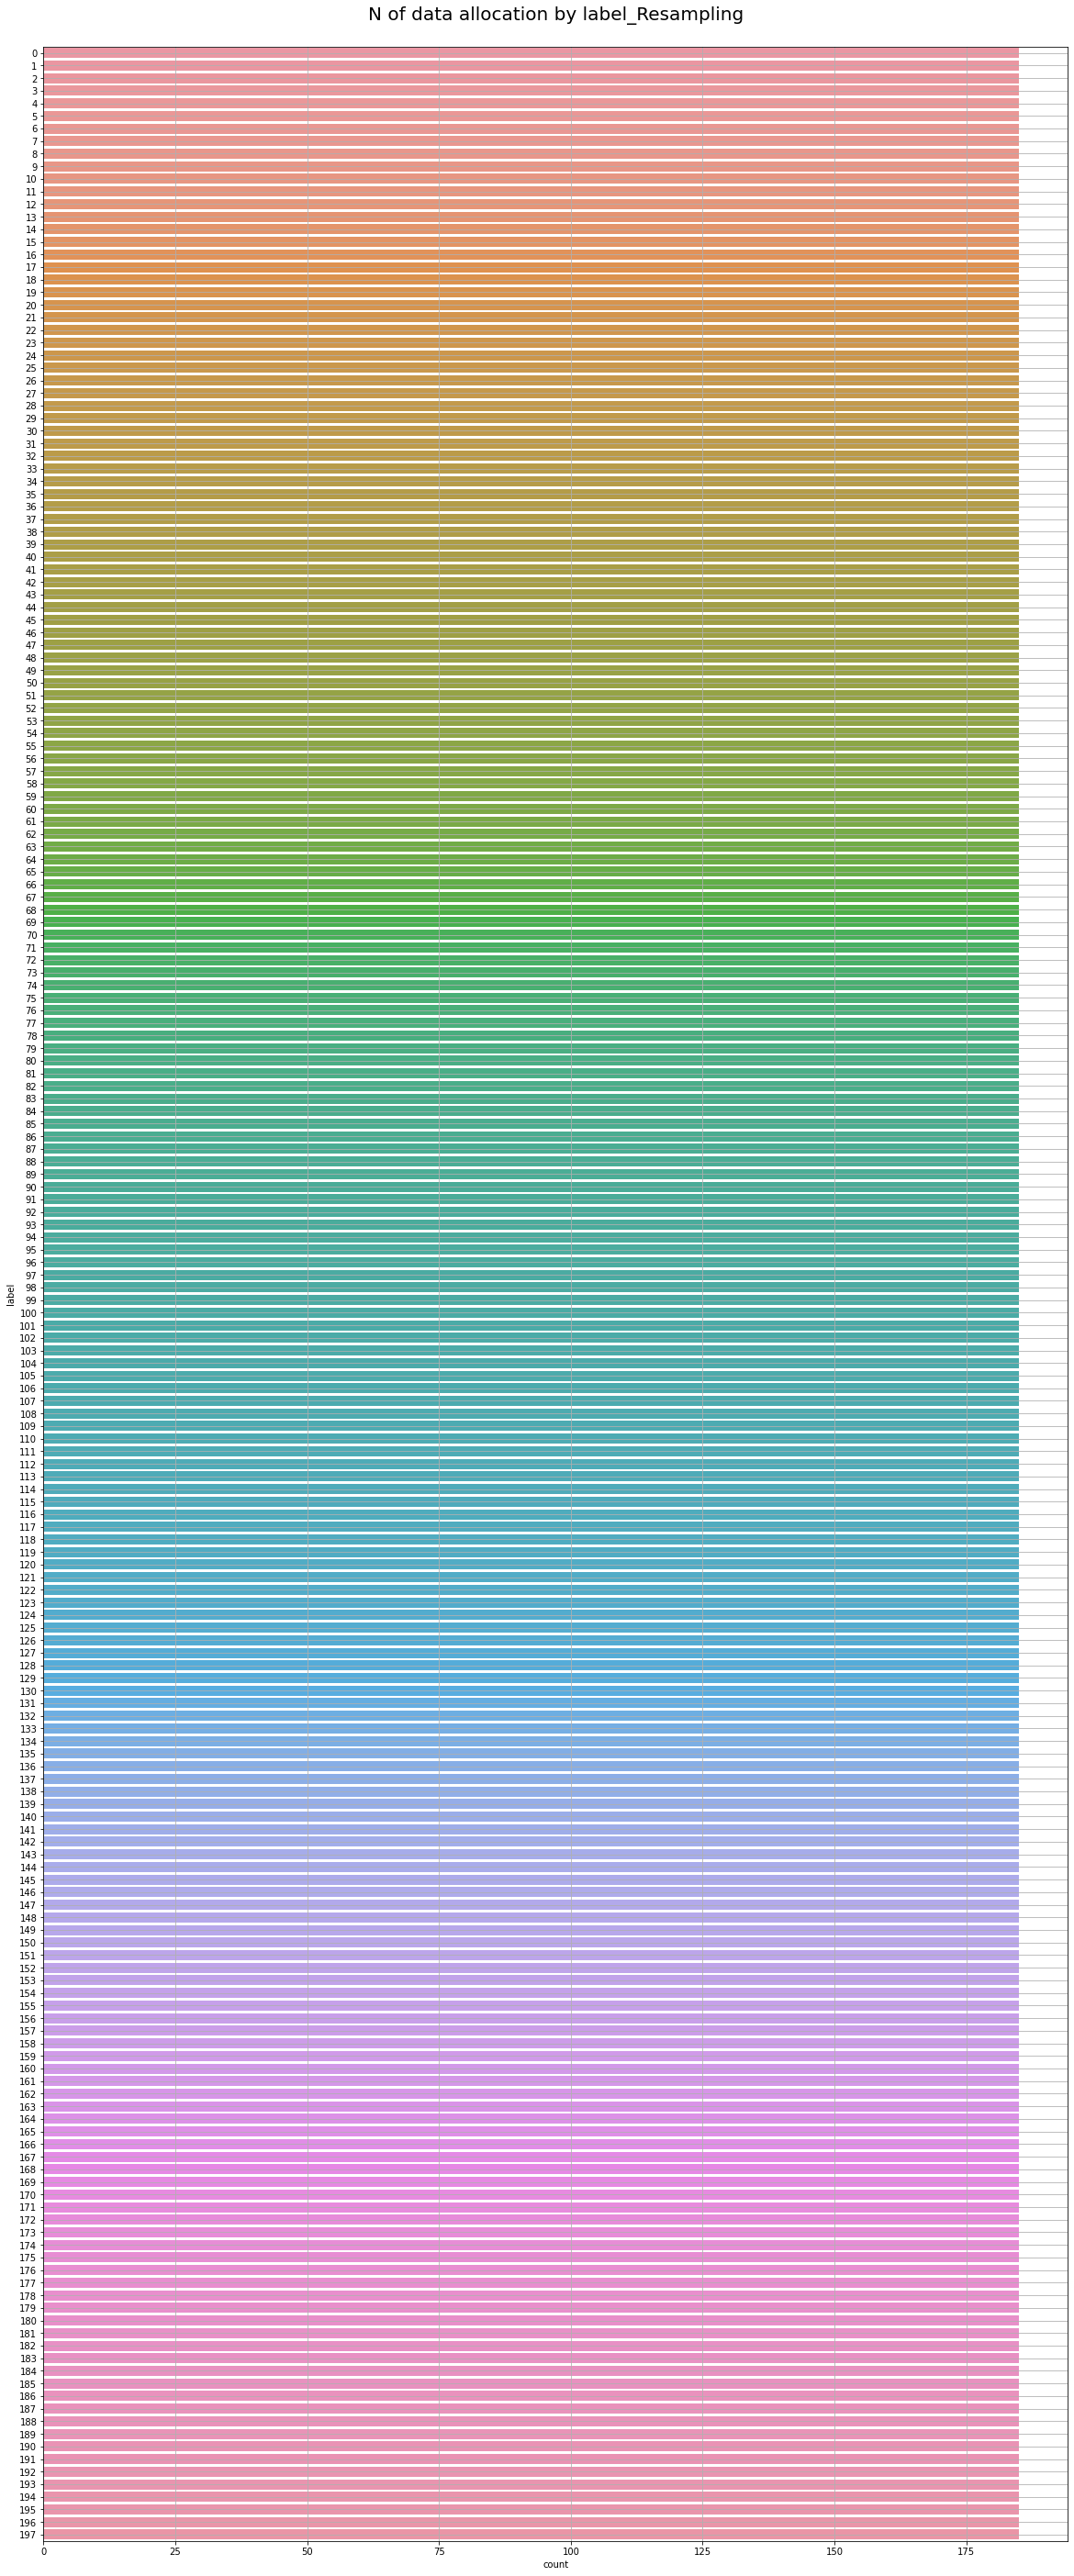

In [14]:
#리샘플링 결과 라벨 별 분포도
plt.figure(figsize=(20, 50))
sns.countplot(y=y_train)

plt.title('N of data allocation by label_Resampling\n', size=20)
plt.grid()
plt.show()

리샘플링 결과의 성능 평가를 위해 단순 rf 모델을 사용하여 원본 데이터 결과와 비교해 보았습니다. 원본 데이터의 결과는 첫번째 게시물 또는 아래 결과 화면 사진을 참고해 주세요.

![rf결과](https://ifh.cc/g/RjptJQ.jpg)

In [13]:
#리샘플링 성능평가
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf_3=RandomForestClassifier(n_estimators=300, random_state=156)
scores = cross_val_score(rcf_3, X_train, y_train, scoring='accuracy', cv=3)
print('CV3인 경우 개별 fold 세트별 정확도 : ', scores)
print('평균 정확도 : {0:.4f}'.format(np.mean(scores)))

CV3인 경우 개별 fold 세트별 정확도 :  [0.76764947 0.84987715 0.75438165]
평균 정확도 : 0.7906




리샘플링한 데이터의 rf결과는 평균 정확도 0.7906 정도로 원본 데이터와 큰 차이가 나지 않았습니다. 임의로 파일 id를 배정하였음에도 성능 저하의 폭이 크지 않다는 점을 고려한다면, 랜덤하게 id를 배정하거나 분산 분석을 통해 대표값을 할당한다면 훨씬 더 높은 정확도를 얻을 수 있을 것으로 예상됩니다. 



---

### 5. 차원축소

첫번째 게시글을 통해 칼럼을 약 2000여개를 drop 하였지만, 그럼에도 약 3000개의 칼럼이 남아 있습니다. 데이터의 경향성과 압축 가능성을 확인하기 위해 차원축소를 진행하였습니다. 차원축소는 비지도 차원축소 방식인 PCA를 적용하였습니다.

In [19]:
# 스케일링
scaler = StandardScaler()
df_scaled=scaler.fit_transform(X_train)

In [20]:
# pca 차원축소
pca=PCA(n_components=3)
df_pca = pca.fit_transform(df_scaled)

결과를 3차원 그래프로 시각화하여 확인해보겠습니다.

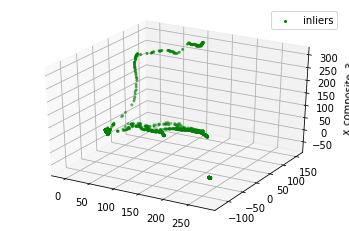

In [22]:
#시각화
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")

ax.scatter(df_pca[:, 0], df_pca[:, 1], zs=df_pca[:, 2], s=4, lw=1, label="inliers",c="green")
ax.legend()
plt.show()

어느 정도의 경향성을 가지지만, 일부 이상치로 볼 수 있는 데이터도 존재하는 것 처럼 보입니다. 압축 가능성을 확인하기 위해 단순 rf모델로 성능 비교를 진행했습니다.

In [26]:
# 차원축소 성능평가
rcf=RandomForestClassifier(n_estimators=300, random_state=156)
scores_pca = cross_val_score(rcf,df_pca, y_train, scoring='accuracy')

print('CV3인 경우 PCA변환된 개별 fold 세트별 정확도 : ', scores_pca)
print('PCA 변환 데이터 세트 평균 정확도 : {0:.4f}'.format(np.mean(scores_pca)))

CV3인 경우 PCA변환된 개별 fold 세트별 정확도 :  [0.05309855 0.10810811 0.13772864 0.13745564 0.13390663]
PCA 변환 데이터 세트 평균 정확도 : 0.1141




그러나 실제 rf 결과는 예상과 많이 달랐습니다. 평균 정확도 약 0.1141 정도로 상당히 성능이 저하된 것을 확인할 수 있습니다. 스케일링의 문제인가 싶어 standard 외 robust, minmax 등을 적용하여 비교하였으나, 성능에 큰 변화는 없었습니다.

따라서, 차원 축소를 적용하는 것은 적절하지 않다고 판단됩니다.

----

### 6. 이상치탐색

지금까지 칼럼 축소를 위주로 데이터 EDA를 진행하였는데, 이제 train 데이터셋의 row 데이터를 좀 더 살펴보겠습니다. 우리가 사용하고 있는 데이터 로드 모듈, data_loader_v2.py를 보면, 불러온 train 데이터의 row는 file id임을 알 수 있습니다.

따라서 row를 기준으로 이상치 탐색을 진행하면, 비교적 중요도가 낮은 file id를 제거할 수 있습니다. lsolation forest를 적용하여 이상치를 탐색을 진행했습니다. contamination변수를 0.01로 설정하여 전체 데이터 중 1%를 이상치로 간주하고 lf모델을 통해 이상치를 탐색한 결과입니다.

In [37]:
from sklearn.ensemble import IsolationForest
lf=IsolationForest(n_estimators=50, max_samples=50, contamination=float(0.01), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=None, verbose=0,behaviour="new")
lf.fit(X_train)

pred = lf.predict(X_train)
X_train['out']=pred

C:\Users\jih02\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:255: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


In [51]:
# 1이면 정상, -1이면 이상치 포함된 index
tmp=X_train.loc[X_train['out']==-1]
out_index=list(tmp.index)

In [43]:
# 이상치 row
tmp

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5085,V5086,V5087,V5088,V5089,V5090,V5115,V5118,V5119,out
103,23.559128,4.274427,4.250021,3.751442,3.759234,-8.291305,34.442123,2.650298e+02,0.0,261.567632,...,110.859694,-0.300430,-0.234850,-0.148066,-0.148180,43.194587,0.1000,70.678227,8.82437,-1
103,23.544267,4.354535,4.258811,3.740691,3.782363,2.535554,6.121905,2.650298e+02,0.0,261.565717,...,110.921065,-0.301900,-0.229540,-0.225293,-0.141646,43.199915,0.1000,70.678226,8.82437,-1
103,23.538900,4.288717,4.233603,3.788568,3.805828,2.925952,-7.025525,2.650298e+02,0.0,261.564724,...,110.941848,-0.303200,-0.257178,-0.270651,-0.188651,43.197637,0.1000,70.678220,8.82437,-1
103,23.561275,4.308862,4.239103,3.765229,3.797751,13.439356,-27.703969,2.650298e+02,0.0,261.568362,...,110.876239,-0.292275,-0.222797,-0.185541,-0.161072,43.191146,0.1000,70.678230,8.82437,-1
103,23.546555,4.228655,4.257381,3.758402,3.783031,-15.119784,-10.500483,2.650298e+02,0.0,261.567716,...,110.877679,-0.288895,-0.245284,-0.236787,-0.170444,43.205434,0.1000,70.678220,8.82437,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,24.044489,4.286894,4.213520,3.786237,3.782339,-1.313453,-21.468657,2.651105e+02,0.0,261.569403,...,110.912965,-0.272413,-0.246441,-0.198147,-0.145400,43.193136,0.1000,70.678221,8.82437,-1
176,24.059724,4.353295,4.240205,3.774026,3.795141,8.448634,-20.689173,2.651098e+02,0.0,261.569243,...,110.848742,-0.293415,-0.233067,-0.183883,-0.140670,43.203261,0.1000,70.678225,8.82437,-1
176,24.046723,4.269111,4.266959,3.749095,3.772972,8.307168,-17.935429,2.651105e+02,0.0,261.570471,...,110.971647,-0.307250,-0.241933,-0.174509,-0.140263,43.189406,0.1000,70.678208,8.82437,-1
176,24.054898,4.275377,4.252281,3.760244,3.782365,19.138578,-37.828581,2.651105e+02,0.0,261.569444,...,110.931214,-0.282216,-0.227733,-0.212222,-0.163397,43.196402,0.1000,70.678223,8.82437,-1


총 367개의 칼럼이 탐색되었습니다. 중복값을 제거하지 않은 out_index를 보면 이상치로 판단된 file id는 대부분 103, 176 위주로, 해당 file id만을 drop하기로 결정했습니다. 결과는 다음과 같습니다.

In [52]:
print(out_index)

[103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176, 176,

In [53]:
# id 103, 176만 삭제
out_index.remove(290)
X_train = X_train.drop(['out'], axis=1)

X_train = X_train.drop(out_index)
y_train = y_train.drop(out_index)

In [60]:
X_train.shape, y_train.shape

((36260, 3455), (36260,))

In [61]:
# 제거한 row
X_train

,V0000,V0001,V0002,V0003,V0004,V0005,V0006,V0007,V0008,V0009,...,V5084,V5085,V5086,V5087,V5088,V5089,V5090,V5115,V5118,V5119
0,30.469574,8.722739,8.686953,8.677701,8.696935,215.779134,148.857105,-8.951266e-20,0.0,-0.000694,...,110.922023,110.958197,-0.298096,-0.234462,-0.241420,-0.164439,43.197957,60.0,-2.988467e-06,85.4
0,30.471422,8.843733,8.724614,8.736648,8.724141,189.935527,186.819255,5.018471e-19,0.0,0.001233,...,110.918918,110.930774,-0.311288,-0.229316,-0.230339,-0.174198,43.194910,60.0,1.136327e-05,85.4
0,30.465795,8.639923,8.693430,8.706842,8.698667,167.172015,227.642581,5.601811e-19,0.0,0.000029,...,110.923194,110.877289,-0.275290,-0.247143,-0.175712,-0.179520,43.206854,60.0,1.157871e-06,85.4
0,30.451257,8.643156,8.721100,8.677412,8.697360,190.645984,181.005102,4.328276e-19,0.0,-0.001779,...,110.822725,110.848307,-0.286780,-0.240937,-0.212229,-0.157415,43.198779,60.0,4.229167e-06,85.4
0,30.469449,8.786702,8.718487,8.632532,8.686938,208.447021,202.666961,3.835715e-19,0.0,-0.000019,...,110.810634,110.926518,-0.301789,-0.237373,-0.201726,-0.188566,43.204087,60.0,1.503048e-06,85.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,30.466798,8.781396,8.656021,8.741145,8.678219,183.032479,198.732448,5.160292e-19,0.0,-0.002553,...,110.878279,110.853071,-0.292044,-0.230561,-0.188257,-0.138816,43.196687,60.0,4.202532e-07,85.4
822,30.487399,8.813155,8.718072,8.723063,8.724389,209.083991,153.851021,-6.571058e-19,0.0,0.000800,...,110.852287,110.798022,-0.281708,-0.233645,-0.252706,-0.165436,43.201587,60.0,3.512496e-07,85.4
822,30.467739,8.752970,8.674999,8.683145,8.694938,194.415606,250.116154,4.640560e-20,0.0,-0.001554,...,111.049257,110.944531,-0.293674,-0.216244,-0.205386,-0.175538,43.207345,60.0,-6.612851e-06,85.4
822,30.451295,8.725999,8.702534,8.673263,8.707673,216.079464,197.389922,-1.351444e-19,0.0,-0.000090,...,111.054845,111.045120,-0.287287,-0.242544,-0.238269,-0.135583,43.199317,60.0,-3.596244e-05,85.4


In [62]:
#file id제거 성능평가
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rcf=RandomForestClassifier(n_estimators=300, random_state=56)
scores = cross_val_score(rcf, X_train, y_train, scoring='accuracy', cv=3)
print('CV3인 경우 개별 fold 세트별 정확도 : ', scores)
print('평균 정확도 : {0:.4f}'.format(np.mean(scores)))

CV3인 경우 개별 fold 세트별 정확도 :  [0.66302639 0.84346819 0.75268906]
평균 정확도 : 0.7531


In [ ]:
print("CV3인 경우 개별 fold 세트별 정확도 :  [0.76302639 0.84346819 0.85268906]\n평균 정확도 : 0.8197")

In [65]:
from sklearn.tree import export_graphviz

model = clf.estimators_[3]
# .dot 파일로 export 해줍니다
export_graphviz(model, out_file='tree.dot')

# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'iForest-tree.png', '-Gdpi=600'])

# jupyter notebook에서 .png 직접 출력
from IPython.display import Image
Image(filename = 'iForest-tree.png')

FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다

In [67]:
pip install subprocess

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement subprocess (from versions: none)
ERROR: No matching distribution found for subprocess
You should consider upgrading via the 'C:\Users\jih02\AppData\Local\Continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


In [68]:
# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'iForest-tree.png', '-Gdpi=600'])

# jupyter notebook에서 .png 직접 출력
from IPython.display import Image
Image(filename = 'iForest-tree.png')

FileNotFoundError: [WinError 2] 지정된 파일을 찾을 수 없습니다

In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0, verbose=1, n_jobs=-1,
                               n_estimators=300, min_samples_leaf=5, max_depth=20)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=1,
                       warm_start=False)

In [ ]:
# GridSearchCV - Not run (lack of memory)

params = {'n_estimators':[100],'max_depth':[8, 12, 50],'min_samples_leaf':[8, 18, 100],'min_samples_split':[8, 20, 100]}

model = RandomForestClassifier(random_state=0, verbose=1, n_jobs=-1)
grid_cv = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('best parameter set :\n', grid_cv.best_params_)
print(f'best accuracy : {grid_cv.best_score_:.4f}')

In [24]:
#피쳐 중요도 확인
ftr_tmp = model.feature_importances_
ftr_importances = pd.Series(ftr_tmp, index=X_train.columns)

Index(['V0046', 'V0050', 'V0087', 'V0088', 'V0089', 'V0135', 'V0188', 'V0201',
       'V0215', 'V0220',
       ...
       'V4979', 'V4984', 'V4992', 'V4998', 'V5006', 'V5013', 'V5016', 'V5019',
       'V5020', 'V5115'],
      dtype='object', length=868)

In [25]:
ftr_importances[ftr_importances==0].index

Index(['V0046', 'V0050', 'V0087', 'V0088', 'V0089', 'V0135', 'V0188', 'V0201',
       'V0215', 'V0220',
       ...
       'V4979', 'V4984', 'V4992', 'V4998', 'V5006', 'V5013', 'V5016', 'V5019',
       'V5020', 'V5115'],
      dtype='object', length=868)

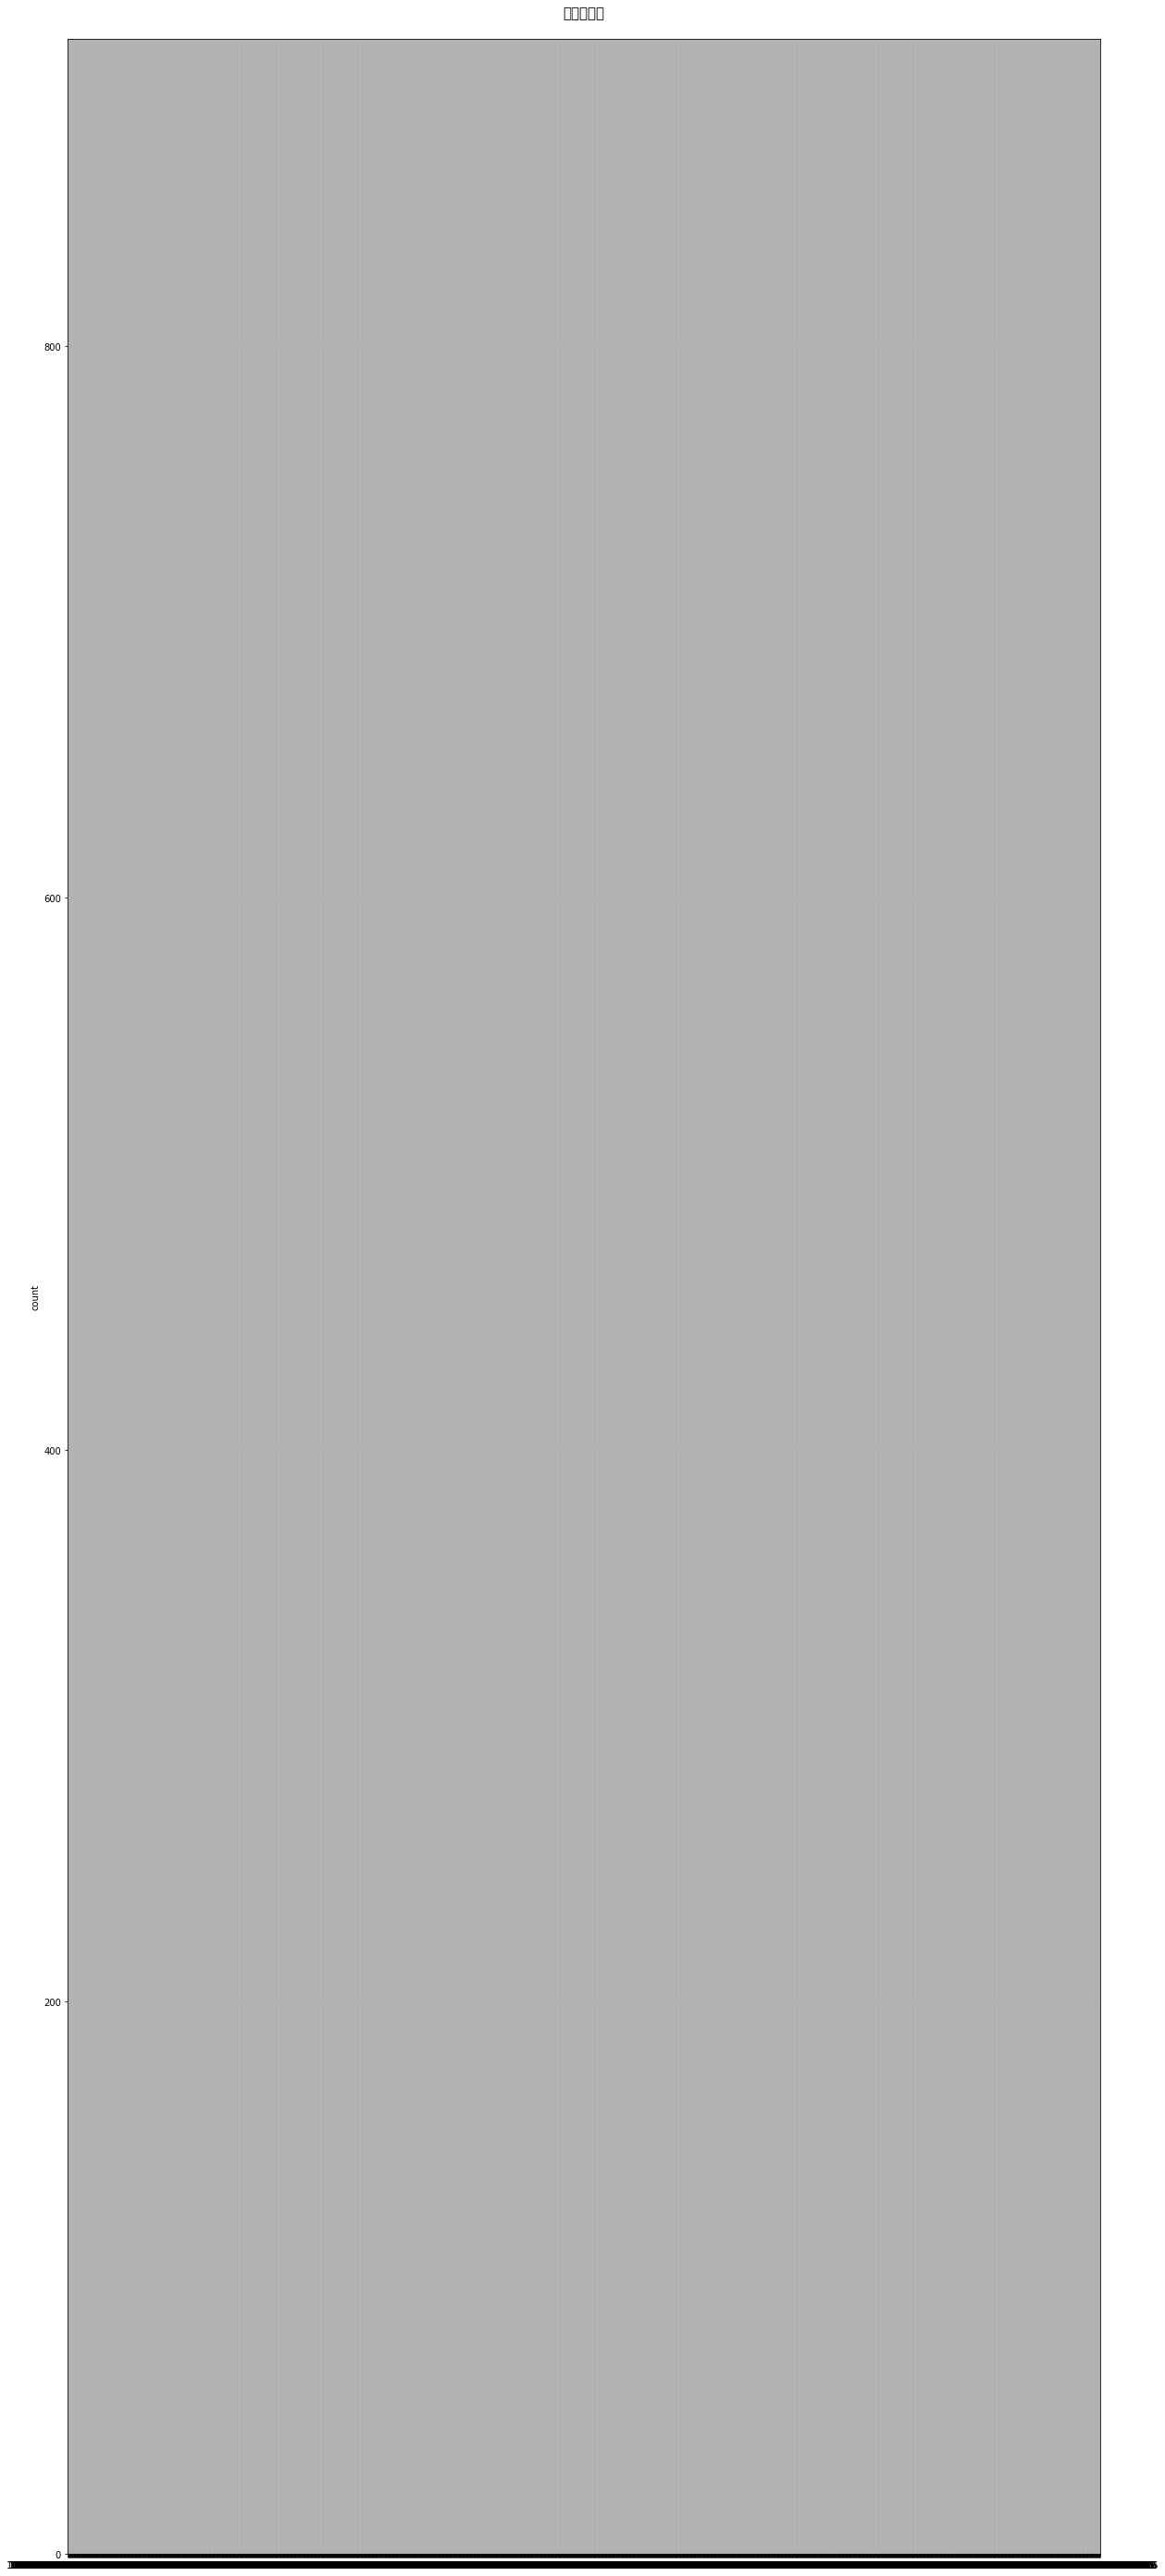

In [30]:
#라벨 별 분포도
plt.figure(figsize=(20, 50))
sns.countplot(x=ftr_importances)

plt.title('피처중요도\n', size=15)
plt.grid()
plt.show()

저장

In [41]:
train = np.load('train.npz')

In [42]:
X = train['X']
y = train['y']

In [43]:
X.shape

(36630, 3365)

In [44]:
#중요도 낮은 피처 제거
X_train_new = X.loc[:, ftr_importances[ftr_importances>=5].index]  

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [40]:
X_train_new.shape

(36630, 0)

In [33]:
np.savez('train.npz', X=X_train, y=y_train)

In [ ]:
X_train_new['label'] = y_train

In [ ]:
X_train_new.to_csv('X_train_new.csv')